In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
import os
# os.environ["PYTHONPATH"]="/custom"
import cppyy.ll
cppyy.ll.set_signals_as_exception(True)
import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy.SI import mm, cm, m, eV, MeV, GeV, twopi, deg

import random
gRunManager = g4.G4RunManager()

[G4PPYY] : Geant4 Python wrapper for CPPYY
[G4PPYY] : author: P. Stowell
[G4PPYY] : Loading G4 Modules.
[G4PPYY] : G4PREFIX : /app/geant4-v11.2.2/install
[G4PPYY] : G4VERSION : 11.2.2
[G4PPYY] : Module loading complete.
[G4PPYY] : Imported all definitions.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************



In [2]:
# g4.cppyy.include("G4VUserDetectorConstruction.hh")
# g4.cppyy.include("G4VUserPrimaryGeneratorAction.hh")
# g4.cppyy.include("G4VPhysicalVolume.hh")

In [3]:
# !DYLD_LIBRARY_PATH=$LD_LIBRARY_PATH; otool -l /Users/stowell/Research/Software/G4/geant4-v11.1.1-install/lib/libG4ToolsSG.dylib | grep name

In [4]:
# !ls /usr/lib/

In [5]:

class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Moderated Cf252 Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4Neutron.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(1, 0, 0))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        energy = 14 * MeV #beam_energy
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(-40*cm,-1*cm + 5*cm*random.random(),-1*cm + 5*cm*random.random()))
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)



class neutron_tracker(g4.G4VSensitiveDetector):

    def Reset(self):
        self.neutron_event = {
            "eid": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": []        
        }
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())
        if not (pdg == 2112): return 0

        eid = int(gRunManager.GetCurrentEvent().GetEventID())

        self.neutron_event["eid"].append( eid )
        
        pos = aStep.GetPreStepPoint().GetPosition() 
        dirs = aStep.GetTrack().GetMomentumDirection() 
        ek = aStep.GetPreStepPoint().GetTotalEnergy() 

        self.neutron_event["edep"].append(aStep.GetTotalEnergyDeposit())
        self.neutron_event["x"].append(pos.x())
        self.neutron_event["y"].append(pos.y())
        self.neutron_event["z"].append(pos.z())
        
        aStep.GetTrack().SetTrackStatus(g4.G4TrackStatus.fStopAndKill)

        return 1

    def StartOfRunAction(self):
        self.Reset()

    def EndOfRunAction(self):
        self.df = pd.DataFrame(data=self.neutron_event)

    def VisualizationAction(self):
        
        plt.scatter(self.df.x, self.df.y, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XY Edep")
        plt.xlabel("x [mm]")
        plt.ylabel("z [mm]")
        plt.show()
        
        plt.scatter(self.df.x, self.df.z, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XZ Edep")
        plt.xlabel("x [mm]")
        plt.xlabel("z [mm]")
        
        
        plt.show()


class custom_world(g4.cppyy.gbl.G4VUserDetectorConstruction):         
    def BuildMaterials(self):
        # Material definitions
        self.water_mat = g4.gNistManager.FindOrBuildMaterial("G4_WATER")

    def BuildWorld(self):
        # Mother Box
        self.world = g4.builder.build_component("world", solid="box", x=5*m, y=5*m, z=5*m, material=self.water_mat, drawstyle="wireframe")

        # World Geometries        
        self.hdpe_outer   = g4.builder.build_component("shell", solid="tubs", rot=[90*deg, 0.0, 0.0], rmax=22*cm, z=1.2*m/2, mother=self.world, material="G4_POLYETHYLENE", color=[0.0,0.0,1.0,0.8], drawstyle="solid")
        self.water_inner  = g4.builder.build_component("water", solid="tubs", rmax=18*cm, z=1.2*m/2, mother=self.hdpe_outer, material="G4_WATER", color=[0.5,0.5,1.0,0.1], drawstyle="solid")
        self.hdpe_endcap1 = g4.builder.build_component("cap1", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, +1.2*m/2 - 1*cm])
        self.hdpe_endcap2 = g4.builder.build_component("cap2", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, -1.2*m/2 + 1*cm])

        self.hdpe_endcap3 = g4.builder.build_component("cap3", solid="sphere", rmax=18*cm, z=1*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,0.1,1.0,0.8], drawstyle="solid", pos=[+2.0*m, 0.0, -1.2*m/2 + 1*cm])
        self.hdpe_endcap4 = g4.builder.build_component("cap4", solid="box", x=30*cm, y=12*cm, z=10*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,1.0,0.1,0.8], drawstyle="solid", pos=[0.0*m, +1.0*m, -1.2*m/2 + 1*cm])

    def BuildDetectors(self):
        # Sensitive Volume Definitions
        self.hdpe_det = neutron_tracker("hdpe_det")
        self.world_det = neutron_tracker("world_det")
        
        self.world.GetLogicalVolume().SetSensitiveDetector(self.world_det)
        self.hdpe_outer.GetLogicalVolume().SetSensitiveDetector(self.hdpe_det)

        g4.run.register_detector_hooks(detector.hdpe_det)
        g4.run.register_detector_hooks(detector.world_det)

    def Construct(self):
        self.BuildMaterials()
        self.BuildWorld()
        self.BuildDetectors()
        
        # Return the mother
        return self.world # top mother volume


<<< Geant4 Physics List simulation engine: QGSP_BERT

Running initializer
Available UI session types: [ tcsh, csh ]
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0
Listing models available in /vis/modeling/trajectories
Registered model factories:
  generic
  drawByAttribute
  drawByCharge
  drawByOriginVolume
  drawByParticleID
  drawByEncounteredVolume

Registered models: 
  Current: drawByParticleID-0
1 not found 
29055 19554 50000


Output()

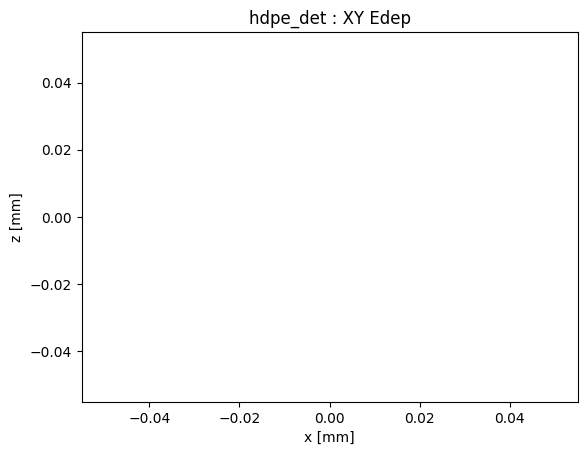

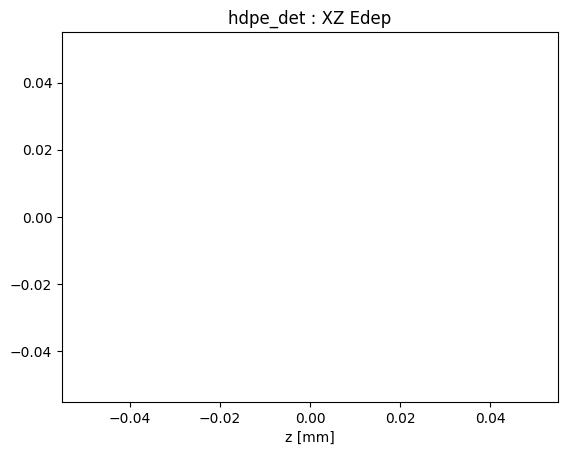

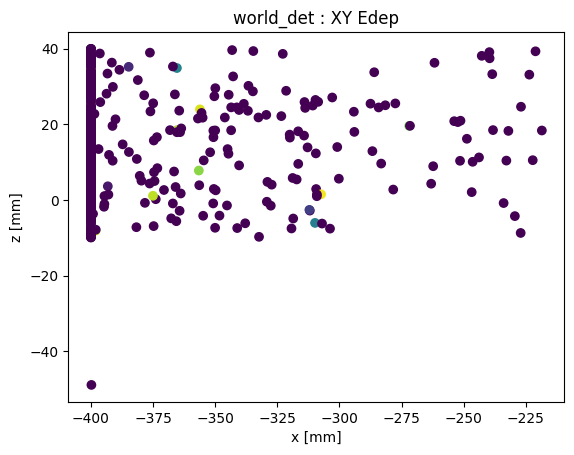

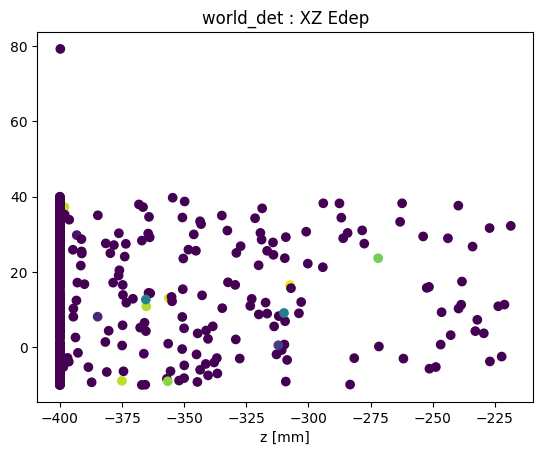

FINISHED


In [6]:
# In [4]:
# Add Physics List
physics = g4.QGSP_BERT()
gRunManager.SetUserInitialization(physics)

# Add a World
detector = custom_world()
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = custom_generator()
gRunManager.SetUserAction(gen)

# Add standard GEANT4 Actions
g4.run.add_default_actions(gRunManager)

# Setup vis to check geometry (optioonal)
g4.run.create_visualization(gRunManager)

g4.mc.vis.scene.add.trajectories("rich")

traj_mc = g4.mc.vis.modeling.trajectories
traj_mc.create.drawByParticleID()
traj_mc.drawByParticleID_0.default.setDrawStepPts(True)
traj_mc.drawByParticleID_0.default.setStepPtsSize(1)
traj_mc.list(1)
traj_mc.drawByParticleID_0.set("e+","grey")
traj_mc.drawByParticleID_0.set("e-","grey")
traj_mc.drawByParticleID_0.set("gamma","yellow")
traj_mc.drawByParticleID_0.set("neutron","magenta")

# Generate some events
g4.run.handle_beam(gRunManager, 1000)

# Draw the vis plot (optional)
g4.run.draw_visualization(gRunManager)


# g4.mc.run.beamOn(1000)
print("FINISHED")